In [1]:
import pandas as pd
import numpy as np

In [2]:
from models.dynamic_models.single_step import single_step_area
from models.dynamic_models.visuializer import show_facility_location
from models.dynamic_models.pareto import get_pareto_curve
from models.dynamic_models.two_step_constrained import two_step_constrained
from models.dynamic_models.naive_multistep import get_naive_curve
from models.dynamic_models.naive_ordered import get_ordered_curve

#data constants
distances_df = pd.read_csv("data/ermera_full/processed/distances.csv").drop(columns=["Unnamed: 0"])
distances = distances_df.to_numpy()
homes = pd.read_csv("data/ermera_full/processed/populations.csv").drop(columns=["Unnamed: 0"])
locations = pd.read_csv("data/ermera_full/processed/facilities.csv").drop(columns=["Unnamed: 0"])
periods_df = pd.DataFrame([1,2,3,4])
periods = periods_df[0]
per_period = 2
max_distance = 3
open_facilities = locations["is_built"]
vpop = homes["Population"]

xC = homes['Pop_Lon']
yC = homes['Pop_Lat']
xF = locations['Grid_Lon']
yF = locations['Grid_Lat']

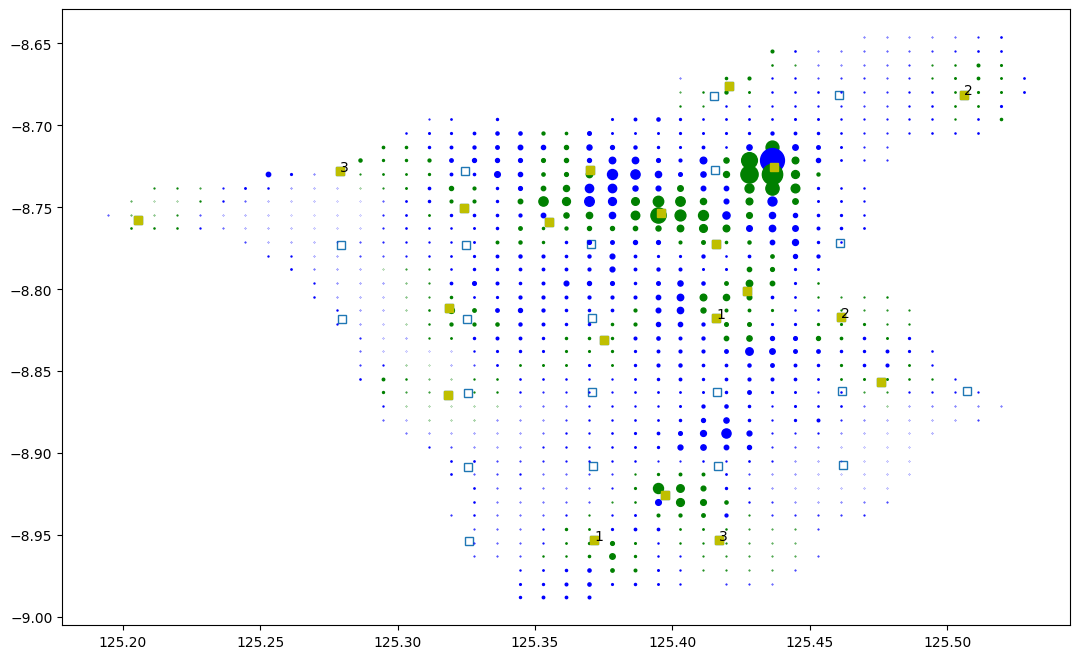

In [3]:
Z, X, building = single_step_area(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)
Z_constrained, X_constrained, constrained_curve = two_step_constrained(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)
Z_pareto, X_pareto, pareto_curve = get_pareto_curve(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)
Z_naive, X_naive, naive_curve = get_naive_curve(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)
Z_ordered, X_ordered, ordered_curve = get_ordered_curve(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)

show_facility_location(xC, yC, xF, yF, X=X_constrained, Z=Z_constrained, homes=homes, locations=locations, periods=periods, vpop=vpop)

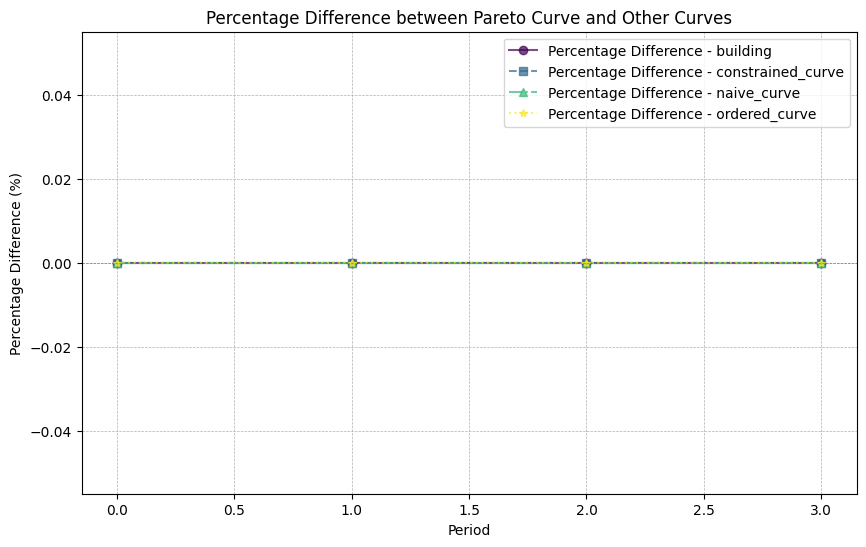

In [4]:
from utils.compare_curves import plot_percentage_differences

pareto_curve = pareto_curve
other_curves = [building, constrained_curve, naive_curve, ordered_curve]
labels = ["building", "constrained_curve", "naive_curve", "ordered_curve"]

plot_percentage_differences(pareto_curve, other_curves, labels)

# Facilities (1000) == Households (1000)

In [5]:
from utils.create_data import generate_facility_location_instance
service, customers, facilities = generate_facility_location_instance(1000, 1000, 20)

xC = customers['Pop_Lon']
yC = customers['Pop_Lat']
xF = facilities['Grid_Lon']
yF = facilities['Grid_Lat']

In [6]:
distances = service.to_numpy()
homes = customers
locations = facilities
periods_df = pd.DataFrame([1,2,3,4,5,6,7,8,9,10])
periods = periods_df[0]
per_period = 2
max_distance = 3
open_facilities = facilities["is_built"]
vpop = customers["population"]

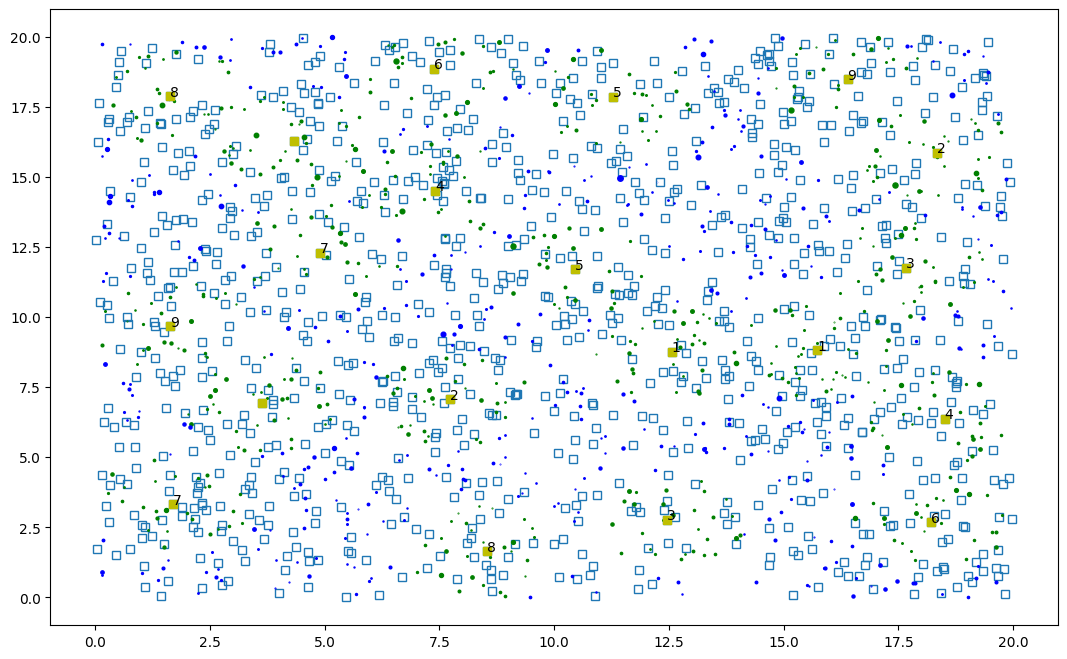

In [7]:
Z, X, building = single_step_area(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)

show_facility_location(xC, 
                       yC, 
                       xF, 
                       yF, 
                       X=X, 
                       Z=Z, 
                       homes=homes, 
                       locations=locations, 
                       periods=periods, 
                       vpop=vpop)

In [8]:
Z_pareto, X_pareto, pareto_curve = get_pareto_curve(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)
#Z, X, building = single_step_area(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)
Z_constrained, X_constrained, constrained_curve = two_step_constrained(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)
Z_naive, X_naive, naive_curve = get_naive_curve(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)
Z_ordered, X_ordered, ordered_curve = get_ordered_curve(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)

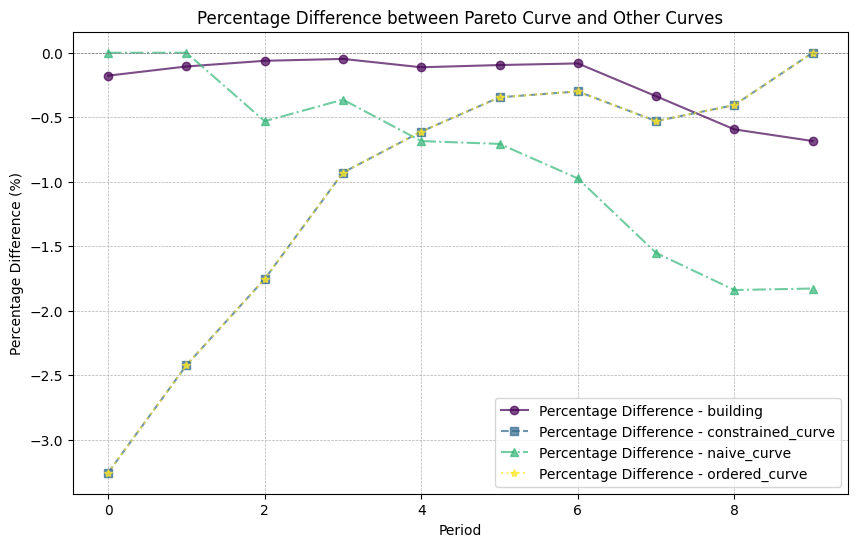

In [9]:
pareto_curve = pareto_curve
other_curves = [building, constrained_curve, naive_curve, ordered_curve]
labels = ["building", "constrained_curve", "naive_curve", "ordered_curve"]

plot_percentage_differences(pareto_curve, other_curves, labels)

# Facilities (100) < Households (10000)

In [10]:
service, customers, facilities = generate_facility_location_instance(100, 10000, 20)

xC = customers['Pop_Lon']
yC = customers['Pop_Lat']
xF = facilities['Grid_Lon']
yF = facilities['Grid_Lat']

distances = service.to_numpy()
homes = customers
locations = facilities
periods_df = pd.DataFrame([1,2,3,4,5,6,7,8,9,10])
periods = periods_df[0]
per_period = 2
max_distance = 3
open_facilities = facilities["is_built"]
vpop = customers["population"]

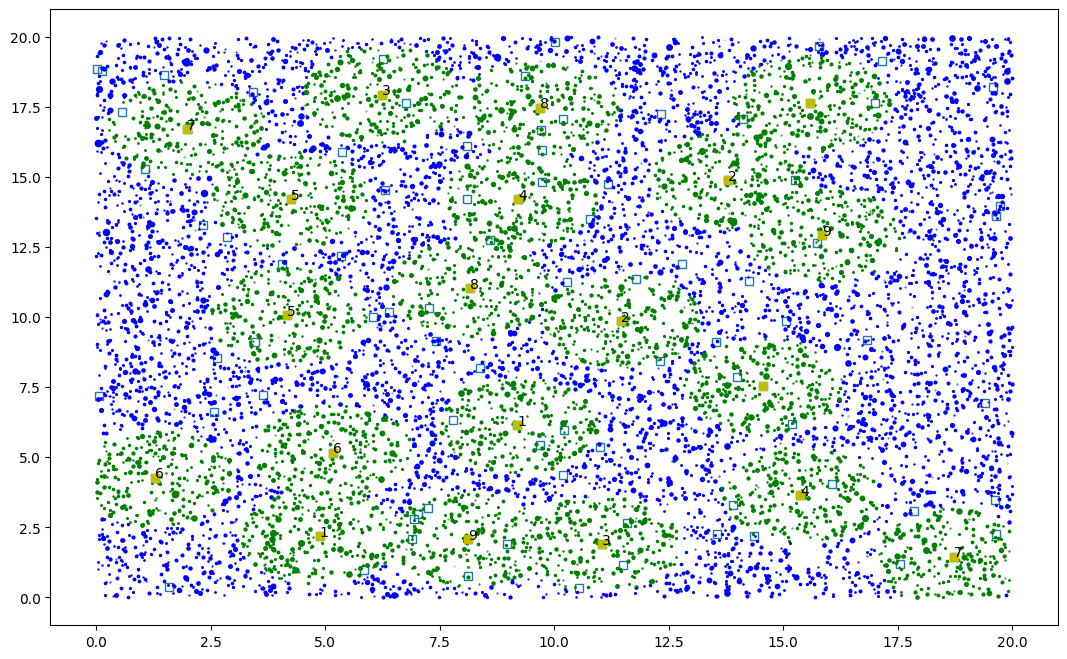

In [11]:
Z, X, building = single_step_area(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)

show_facility_location(xC, 
                       yC, 
                       xF, 
                       yF, 
                       X=X, 
                       Z=Z, 
                       homes=homes, 
                       locations=locations, 
                       periods=periods, 
                       vpop=vpop)

In [12]:
Z_pareto, X_pareto, pareto_curve = get_pareto_curve(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)
#Z, X, building = single_step_area(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)
Z_constrained, X_constrained, constrained_curve = two_step_constrained(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)
Z_naive, X_naive, naive_curve = get_naive_curve(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)
Z_ordered, X_ordered, ordered_curve = get_ordered_curve(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)

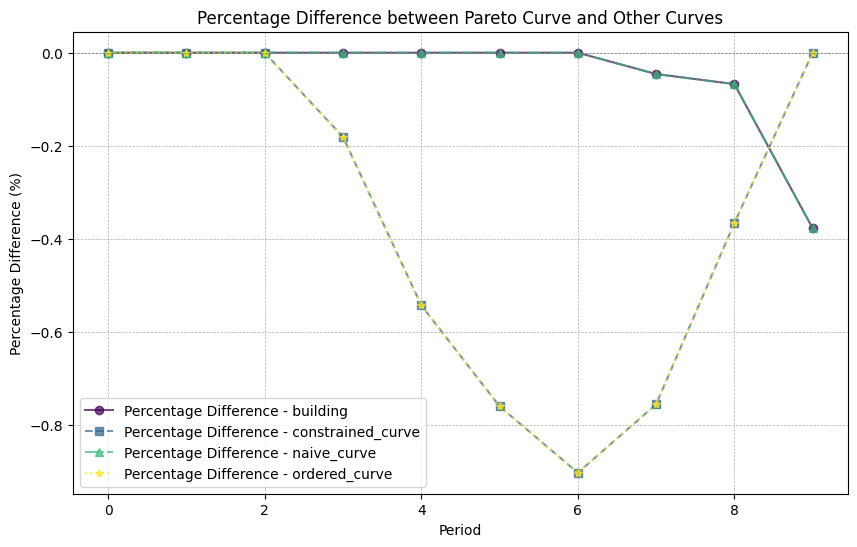

In [13]:
pareto_curve = pareto_curve
other_curves = [building, constrained_curve, naive_curve, ordered_curve]
labels = ["building", "constrained_curve", "naive_curve", "ordered_curve"]

plot_percentage_differences(pareto_curve, other_curves, labels)

# Facilities (10000) > households (100)

In [14]:
service, customers, facilities = generate_facility_location_instance(10000, 100, 20)

xC = customers['Pop_Lon']
yC = customers['Pop_Lat']
xF = facilities['Grid_Lon']
yF = facilities['Grid_Lat']

distances = service.to_numpy()
homes = customers
locations = facilities
periods_df = pd.DataFrame([1,2,3,4,5,6,7,8,9,10])
periods = periods_df[0]
per_period = 2
max_distance = 3
open_facilities = facilities["is_built"]
vpop = customers["population"]

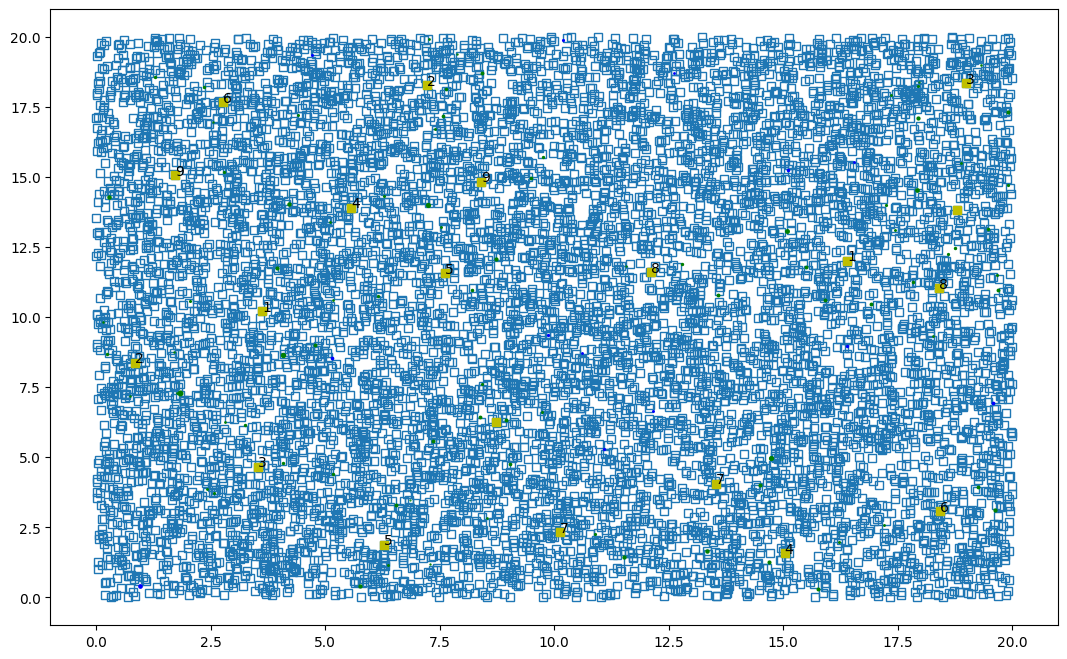

In [15]:
Z, X, building = single_step_area(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)

show_facility_location(xC, 
                       yC, 
                       xF, 
                       yF, 
                       X=X, 
                       Z=Z, 
                       homes=homes, 
                       locations=locations, 
                       periods=periods, 
                       vpop=vpop)

In [16]:
Z_pareto, X_pareto, pareto_curve = get_pareto_curve(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)
#Z, X, building = single_step_area(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)
Z_constrained, X_constrained, constrained_curve = two_step_constrained(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)
Z_naive, X_naive, naive_curve = get_naive_curve(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)
Z_ordered, X_ordered, ordered_curve = get_ordered_curve(distances, homes, locations, periods, per_period, max_distance, open_facilities, vpop)

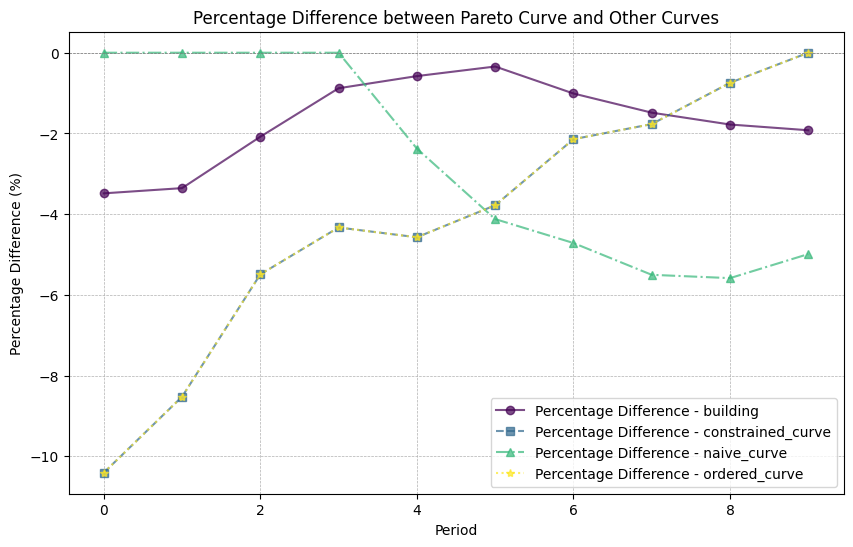

In [17]:
pareto_curve = pareto_curve
other_curves = [building, constrained_curve, naive_curve, ordered_curve]
labels = ["building", "constrained_curve", "naive_curve", "ordered_curve"]

plot_percentage_differences(pareto_curve, other_curves, labels)